<a href="https://colab.research.google.com/github/alicelindel3/ibm5100/blob/main/cp1/automl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# タイタニック号生存者の予測
AutoMLにより、タイタニック号の生存者を予測します。  
訓練済みのモデルによる予測結果は、csvファイルに保存して提出します。  

## PyCaretのインストール
AutoMLをサポートするライブラリ、PyCaretをバージョンを指定してインストールします。

In [ ]:
!pip install pycaret==2.3.6
!pip install pandas-profiling==3.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 301 kB 7.4 MB/s 
     |████████████████████████████████| 17.0 MB 204 kB/s 
     |████████████████████████████████| 2.0 MB 49.6 MB/s 
     |████████████████████████████████| 315 kB 56.7 MB/s 
     |████████████████████████████████| 1.3 MB 56.9 MB/s 
     |████████████████████████████████| 4.8 MB 40.9 MB/s 
     |████████████████████████████████| 25.9 MB 67.2 MB/s 
     |████████████████████████████████| 6.8 MB 28.5 MB/s 
     |████████████████████████████████| 636 kB 47.2 MB/s 
     |████████████████████████████████| 1.7 MB 46.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 167 kB 41.7 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 261 kB 6.7 MB/s 
     |████████████████████████████████| 303 kB 52.5 MB/s 
     |████████████████████████████████| 3.1 MB 50.8 MB/s 
     |████████████████████████████████| 102 kB 14.1 MB/s 
  Attempting uninstall: tangled-up-in-unicode
    Found existing installation: tangled-up-in-unicode 0.2.0
    Uninstalling tangled-up-in-unicode-0.2.0:
      Successfully uninstalled tangled-up-in-unicode-0.2.0
  Attempting uninstall: visions
    Found existing installation: visions 0.7.5
    Uninstalling visions-0.7.5:
      Successfully uninstalled visions-0.7.5
  Attempting uninstall: joblib
    Found existing installation: joblib 1.2.0
    Uninstalling joblib-1.2.0:
      Successfully uninstalled joblib-1.2.0
  Attempting uninstall: pandas-profiling
    Found existing installation: pandas-profiling 3.4.0
    Uninstalling pandas-profiling-3.4.0:
      Succes

## Google Colabの設定
Google Colab環境でPyCaretのインタラクティブな要素を表示するためには、以下のコードを実行する必要があります。

In [ ]:
from pycaret.utils import enable_colab

enable_colab()

Colab mode enabled.


## データの読み込み
以下のページからタイタニック号の乗客データをダウロードして、「train.csv」「test.csv」をノートブック環境にアップします。  
https://www.kaggle.com/c/titanic/data

以下のコードは、これらのデータを読み込みます。  
訓練データには乗客が生き残ったどうかを表す"Survived"の列がありますが、テストデータにはありません。  
訓練済みのモデルに、テストデータを入力して判定した結果を提出することになります。  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

path = "/content/drive/My Drive/Colab Notebooks/"

train_data = pd.read_csv(path+'train_Perished.csv')  # 訓練データ
test_data = pd.read_csv(path+'test_Perished.csv')  # テストデータ

train_data

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,1,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,1,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,0,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,1,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,0,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## 環境の設定
PyCaretの環境を設定します。  
setup関数はPyCaretの環境を初期化しますが、PyCaretの他の関数を実行する前に呼び出す必要があります。      
データの型に問題が無ければ、空白を入力することで設定を完了することができます。  
  
今回のデータには一部欠損があるので、欠損データに対する対応を設定する必要があります。  
`numeric_imputation="mean"`により数値データの欠損には平均値があてがわれ、`categorical_imputation="mode"`によりカテゴリデータの欠損には最頻値があてがわれます。  

https://pycaret.readthedocs.io/en/latest/api/classification.html#pycaret.classification.setup


In [ ]:
from pycaret.classification import setup

clf = setup(data=train_data, target="Perished", session_id=123,  # 環境の初期化
            numeric_imputation="mean", categorical_imputation="mode")

,Description,Value
0,session_id,123
1,Target,Perished
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(891, 12)"
5,Missing Values,True
6,Numeric Features,3
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=['PassengerId'],
                                      ml_usecase='classification',
                                      numerical_features=[], target='Perished',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='most frequent',
                                fill_value_categorical=None,
                                fill_value_numerical=None...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'passthrough'),
        

## モデルの比較
様々なモデルを比較して、性能を評価します。  
compare_models関数は、ライブラリ内のすべてのモデルを使って訓練を行い、スコアを評価します。  

In [ ]:
from pycaret.classification import compare_models

best_model = compare_models()  # 全てのモデルを訓練し、評価する

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8155,0.8576,0.8918,0.8205,0.8543,0.6032,0.6087,0.489
lr,Logistic Regression,0.8122,0.8576,0.8521,0.8412,0.8462,0.6047,0.6060,1.065
ridge,Ridge Classifier,0.8075,0.0000,0.8573,0.8311,0.8438,0.5926,0.5937,0.044
dt,Decision Tree Classifier,0.8042,0.7909,0.8522,0.8310,0.8406,0.5862,0.5886,0.052
et,Extra Trees Classifier,0.8027,0.8494,0.8838,0.8102,0.8451,0.5747,0.5797,0.600
rf,Random Forest Classifier,0.8026,0.8642,0.8892,0.8073,0.8459,0.5733,0.5796,0.674
ada,Ada Boost Classifier,0.7978,0.8485,0.8573,0.8191,0.8368,0.5705,0.5746,0.217
lightgbm,Light Gradient Boosting Machine,0.7849,0.8566,0.8366,0.8169,0.8249,0.5450,0.5496,0.155
lda,Linear Discriminant Analysis,0.7368,0.7353,0.7966,0.7775,0.7856,0.4431,0.4458,0.212
knn,K Neighbors Classifier,0.6919,0.7300,0.7600,0.7408,0.7495,0.3492,0.3509,0.158


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


わずか1行のコードで、15以上の機械学習モデルを訓練し、評価することができました。  
  
最もスコアの良いモデルの概要を表示します。


In [ ]:
print(best_model)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


## モデルの作成
models関数により、全ての使用可能な機械学習モデルを確認することができます。

In [ ]:
from pycaret.classification import models

models()  # 機械学習モデルの一覧

INFO:logs:gpu_param set to False


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


create_model関数は、「交差検証」を用いて個別のモデルの訓練と評価を行います。  
今回は、先程最も精度が高かった「勾配ブースティング」による分類器（Gradient Boosting Classifier）のモデルを作成します。  
勾配ブースティングは弱いモデルが誤差に対して順次学習していく学習方法で、一つの強いモデルを作らず、複数のモデルを組み合わせて強力なモデルとします。  
この弱いモデルとして、決定木がよく使われます。

In [ ]:
from pycaret.classification import create_model

gbc = create_model("gbc")  # 勾配ブースティングのモデルを作成

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8730,0.8542,0.9474,0.8571,0.9000,0.7273,0.7341
1,0.7937,0.8716,0.8421,0.8205,0.8312,0.5660,0.5663
2,0.7460,0.8300,0.7895,0.7895,0.7895,0.4695,0.4695
3,0.8226,0.8076,0.8919,0.8250,0.8571,0.6240,0.6273
4,0.7419,0.7736,0.8421,0.7619,0.8000,0.4389,0.4433
5,0.8387,0.8925,0.9474,0.8182,0.8780,0.6437,0.6589
6,0.8065,0.8761,0.8947,0.8095,0.8500,0.5792,0.5850
7,0.8871,0.9397,0.9474,0.8780,0.9114,0.7565,0.7606
8,0.8387,0.8794,0.8947,0.8500,0.8718,0.6548,0.6564
9,0.8065,0.8514,0.9211,0.7955,0.8537,0.5724,0.5860


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 3
INFO:logs:GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO:logs:create_model() succesfully completed......................................


訓練済みモデルの概要を表示します。  

In [ ]:
print(gbc)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


## ハイパーパラメータの調整
tune_model関数を使用し、ハイパーパラメータを最適化します。

In [ ]:
from pycaret.classification import tune_model

tuned_gbc = tune_model(gbc)  # ハイパーパラメータの調整

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8254,0.8753,0.8947,0.8293,0.8608,0.6276,0.6309
1,0.8095,0.8558,0.8158,0.8611,0.8378,0.6075,0.6088
2,0.7460,0.7637,0.8158,0.7750,0.7949,0.4621,0.4632
3,0.7419,0.7924,0.7568,0.8000,0.7778,0.4707,0.4717
4,0.7097,0.7412,0.7632,0.7632,0.7632,0.3882,0.3882
5,0.8226,0.8761,0.8947,0.8293,0.8608,0.6173,0.6207
6,0.7581,0.8788,0.8684,0.7674,0.8148,0.4698,0.4773
7,0.8871,0.9430,0.8947,0.9189,0.9067,0.7639,0.7643
8,0.8065,0.8651,0.8158,0.8611,0.8378,0.5983,0.5996
9,0.8387,0.8755,0.9211,0.8333,0.8750,0.6493,0.6558


INFO:logs:create_model_container: 16
INFO:logs:master_model_container: 16
INFO:logs:display_container: 4
INFO:logs:GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.4, loss='deviance', max_depth=7,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.3, min_impurity_split=None,
                           min_samples_leaf=4, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=190,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=0.7, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


ハイパーパラメータを調整済みの、モデルの概要を表示します。  

In [ ]:
print(tuned_gbc)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.4, loss='deviance', max_depth=7,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.3, min_impurity_split=None,
                           min_samples_leaf=4, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=190,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=0.7, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


## モデルを評価する
plot_model関数を使い、各特徴量の重要度をプロットします。

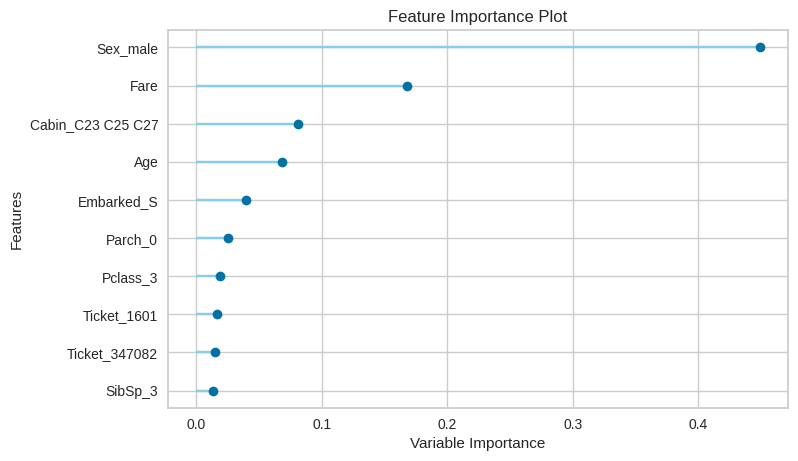

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
from pycaret.classification import plot_model

plot_model(tuned_gbc, plot="feature")  # 各特徴の重要度をプロット

## 本番用のモデルを作成
`finalize_model`関数により全ての訓練データを使ってモデルを訓練し、本番用のモデルを作成します。   

In [ ]:
from pycaret.classification import finalize_model

final_gbc = finalize_model(tuned_gbc)
print(final_gbc)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.4, loss='deviance', max_depth=7,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.3, min_impurity_split=None,
                           min_samples_leaf=4, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=190,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=0.7, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False), fit_kwargs=None, groups=None, model_only=True, display=None)
INFO:logs:Finalizing GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.4, loss='deviance', m

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.4, loss='deviance', max_depth=7,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.3, min_impurity_split=None,
                           min_samples_leaf=4, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=190,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=0.7, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


## 提出用のデータを作成
テストデータを使って予測を行います。  
予測結果には、分類されるクラスを表す「Label」列と、そのクラスに含まれる確率を表す「Score」ラベルが含まれます。

In [ ]:
from pycaret.classification import predict_model

test_pred = predict_model(final_gbc, data=test_data)  # 予測
test_pred.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.4, loss='deviance', max_depth=7,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.3, min_impurity_split=None,
                           min_samples_leaf=4, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=190,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=0.7, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Label,Score
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,1,0.8554
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,0.7024
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1,0.8027
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,1,0.9298
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,0.5451


形式を整えた上で、Kaggleに提出するためのcsvファイルを保存します。

In [ ]:
# 形式を整える
subm_data = test_pred[["PassengerId", "Label"]]  # 列を抜き出す
subm_data = subm_data.rename(columns={"Label" : "Perished"})  # 列名の変更

# 提出用のcsvファイルを保存
subm_data.to_csv("submission_automl.csv", index=False)

subm_data

,PassengerId,Perished
0,892,1
1,893,1
2,894,1
3,895,1
4,896,0
...,...,...
413,1305,1
414,1306,0
415,1307,1
416,1308,1


In [ ]:
from google.colab import files
files.download('submission_automl.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

g:0.788  
k:0.78468